# Description of task
- This is a classification task. 
- In the given data, train.tsv and test.tsv are used for training and testing respectively. The training data is tab sepearted with a label and tokenized sequential data. For example, the tokenized data wr4pi, pze1d, etc.. are actually words of a text document. 
- Each token is a length of 5 (alpha-numeric letters).
- Build your model in this jupyter notebook and submit your prediction results as a csv file along with this notebook
- Try to use PEP 8 style guide.

## Prepare the data. (0pts)

### Load data 

Let us load the training datatset first.


In [ ]:
import pandas as pd

data = pd.read_csv("train.tsv", sep="\t", header=None, names=["Label", "Sequence"])

In [2]:
data.head()

,Label,Sequence
0,3,"wr4pi,pze1d,wkgwb,wr4pi,icxv0,v3b1x,l2mlx,xmdc..."
1,1,"aexn0,wgnih,p0ihu,hqm7o,tyz3h,4z35e,dv288,s7zf..."
2,3,"iudv7,qnzig,tb8xk,u61fl,abm4n,uwewq,wyss6,jpap..."
3,3,"37n9r,m4jp6,2koue,52d37,76axn,cayhm,wyss6,n6tt..."
4,2,"aeqbu,x51ab,52d37,ak17t,9lccc,gq8g5,vorz2,pnvf..."


In [3]:
data.shape

(63799, 2)

## EDA (15pts)

Find unique Labels and their distribution. 

In [4]:
data['Label'].unique()

array([3, 1, 2, 4])

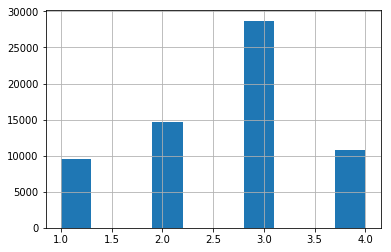

In [5]:
data['Label'].hist()

For information, the classes are not balanced but for building a baseline we will not get interested in balancing classes at this stage (maybe it will be one of ways to improve the performance).

Let us find the length of each sequence, then plot the distribution of lengths. Also we can look at unique words to understand the vocabulary of our dataset.


In [ ]:
len_seq = []
vocabulary = []

for i in range(data.shape[0]):

    tokens = data["Sequence"][i].split(",")
    len_seq.append(len(tokens))
    vocabulary.append(tokens)

assert len(len_seq) == data.shape[0]

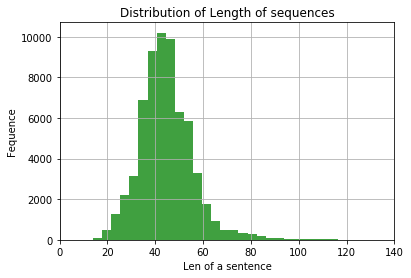

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# the histogram of the data
n, bins, patches = plt.hist(len_seq, 50, density=False, facecolor="g", alpha=0.75)


plt.xlabel("Len of a sentence")
plt.ylabel("Fequence")
plt.title("Distribution of Length of sequences")
plt.xlim(0, 140)
plt.grid(True)
plt.show()

Let us compute the unique tokens in our dataset. I will be converting the vocabulary (list of lists) into a numpy array for better performance in manupaliting arrays.


In [ ]:
all_tokens = np.hstack(vocabulary)

In [9]:
print('total number of tokens in training:', len(all_tokens))
print('unique tokens:', len(np.unique(all_tokens)))

total number of tokens in training: 2853679
unique tokens: 65810


We are facing a 'topic classification' classification problem, where the input is a sequence of words and we have to predict the the associated class. Also from the description of the task, it confirms that the data is a sequence of 5-char tokens, so it is not needed in the direction of data cleaning. 



## Split labelled data into training and validation data set. Then build your model from training data and evaluate your prediction on validation data using suitable metric. (15 pts)

### 1 - Split data to training and valdiation

NB : Usually, we should have a 3rd split of the dataset that we will never use during training/validation, and will be used only once the construction of the model is done. This 'testing' dataset can confirm that performances of the model is preserved on unseen data. For simplicity, we ommited this 3 splits, and we will only use training/validation split.

In [ ]:
from sklearn.model_selection import train_test_split

# 20% for validation
train, validation = train_test_split(data, test_size=0.20, random_state = 666)

In [ ]:
# Get numpy array to represent each observation
# we also replace ',' by ' ' for compatibility to use Sklearn algos

x_train = train['Sequence'].replace(',', ' ', regex=True).values
y_train = train['Label'].values

x_val = validation['Sequence'].replace(',', ' ', regex=True).values
y_val= validation['Label'].values

### 2 - Build a simple model

As a first step, I will be using TF-IDF (https://en.wikipedia.org/wiki/Tf–idf) and a logistic regression to build a text classifier. TfidfVectorizer convert a collection of raw documents to a matrix of TF-IDF features.

In [ ]:
# Define model 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


text_classifier = make_pipeline(
    TfidfVectorizer(min_df=3, max_df=0.8, ngram_range=(1, 2)),
    LogisticRegression(multi_class = 'auto', random_state=0),
)

In [13]:
%%time
# fit the model
_ = text_classifier.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 15.6 s, sys: 5.47 s, total: 21.1 s
Wall time: 14.1 s


              precision    recall  f1-score   support

           1       0.93      0.84      0.89      1924
           2       0.95      0.98      0.96      2896
           3       0.90      0.95      0.92      5709
           4       0.87      0.80      0.83      2231

    accuracy                           0.91     12760
   macro avg       0.91      0.89      0.90     12760
weighted avg       0.91      0.91      0.91     12760

F1-score: 0.901


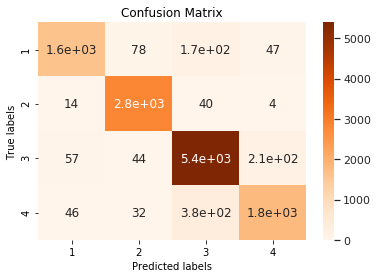

In [14]:

from sklearn import metrics
import seaborn as sn
# Do prediction on validation dataset using trained model
predicted_val = text_classifier.predict(x_val)


# Compute metrics 
print(metrics.classification_report(y_val, predicted_val))
print('F1-score: %.3f' % metrics.f1_score(y_val, predicted_val, average = 'macro'))

df_m = metrics.confusion_matrix(y_val, predicted_val)
ax= plt.subplot()
sn.set(font_scale=1)#for label size
sn.heatmap(df_m, cmap='Oranges', annot=True)# font size
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(text_classifier.classes_); ax.yaxis.set_ticklabels(text_classifier.classes_)
plt.show()


### 3 - Model Search

Now we have a simple model, Let us first try to see other ML models performance and on which one we have to focus. 
In the following plot, we will only observe the training accuracy to give us a hint about the ML model to choose for later analysis. 

- Do TF-IDF : 


In [ ]:
# Define transformer 
tf = TfidfVectorizer(min_df=3, max_df=0.8, ngram_range=(1, 2))

# Fit and transform of training data 
x_tf = tf.fit_transform(x_train)
x_val_tf = tf.transform(x_val)


- Then we define a list of models and do 5-cross-validation using each model and plot the perofmance only on training dataset(this is a time consuming task)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns

# Define a list of models
models = [
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# Nb of Cross Validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

# Fir models
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(
        model, x_tf, y_train, scoring="accuracy", cv=CV, n_jobs=-1
    )
    # Save accuracy/model_name
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))


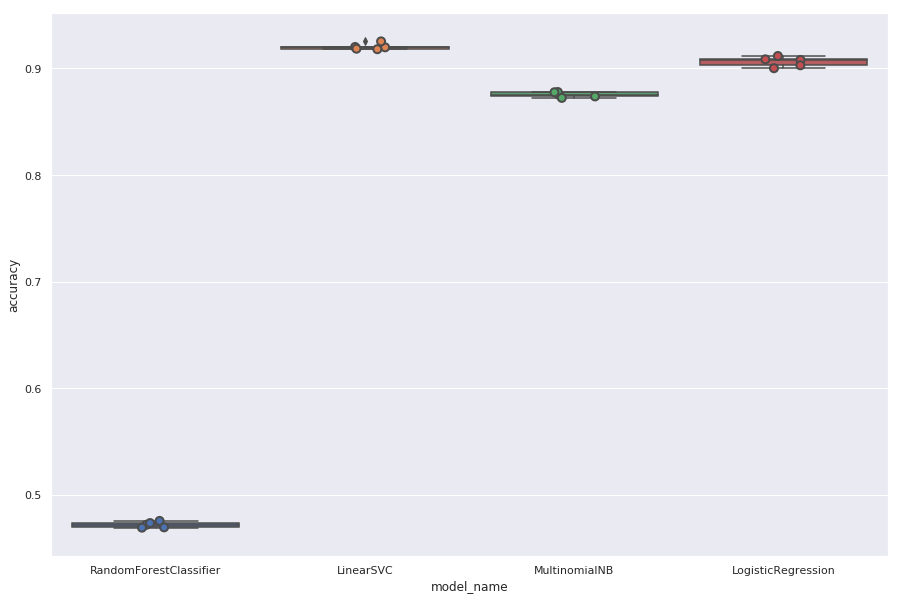

In [17]:
# Plot the accuracy (on trainign!) for each model
cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])
plt.figure(figsize=(15, 10))
sns.boxplot(x="model_name", y="accuracy", data=cv_df)
sns.stripplot(
    x="model_name",
    y="accuracy",
    data=cv_df,
    size=8,
    jitter=True,
    edgecolor="gray",
    linewidth=2,
)
plt.show()

-  Conclusion : 

It seems that LinearSVC is a promising model. We will focus on this model in the following section. let us re-train this model on the training dataset and observe different metrics on the validation dataset.

              precision    recall  f1-score   support

           1       0.92      0.87      0.89      1924
           2       0.96      0.99      0.97      2896
           3       0.92      0.94      0.93      5709
           4       0.86      0.83      0.85      2231

    accuracy                           0.92     12760
   macro avg       0.92      0.91      0.91     12760
weighted avg       0.92      0.92      0.92     12760

F1-score: 0.910


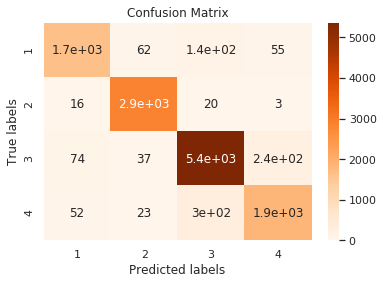

In [18]:
# Train SVC and evaluate on validation data

from sklearn import metrics

# Define model
text_clf = make_pipeline(
    LinearSVC(random_state = 666),
)


# Train model 
_ = text_clf.fit(x_tf, y_train)

# Do prediction on validation dataset 
predicted_val = text_clf.predict(x_val_tf)


# Compute metrics on validation set
print(metrics.classification_report(y_val, predicted_val))
print('F1-score: %.3f' % metrics.f1_score(y_val, predicted_val, average = 'macro'))

df_m = metrics.confusion_matrix(y_val, predicted_val)
ax= plt.subplot()
sn.set(font_scale=1)#for label size
sn.heatmap(df_m, cmap='Oranges', annot=True)# font size
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(text_clf.classes_); ax.yaxis.set_ticklabels(text_clf.classes_);


The perfomance (accuracy, recall and f1 score) on the validation dataset seems to be good. In the context of multi-class classification we will focus on the **f1 score** as it combines recall/precision in one metric. 

### 4 - Parameter Search for SVM

In the next section we will try to do some parameter search for the choosen algorithm. 

Hyperparameter search for SVM. We will focus on the parameter C (Penalty parameter of the error term) of the SVM algorithm. In a more elaborated approach we could have fine-tuned other parameters and also use other hyper-parameter tuning methods (random, or Bayesian optimization).

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Parameter space
tuned_parameters = [{"C": [0.1, 0.5, 1, 2, 10]}]


scores = ["precision", "recall", "f1"]


# Do hyperparameter on multiple metrics
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(
        LinearSVC(random_state=666),
        tuned_parameters,
        cv=5,
        scoring="%s_macro" % score,
        n_jobs=-1,
    )
    clf.fit(x_tf, y_train)

    print("Best parameters set found on development set:")

    print(clf.best_params_)

    print("Grid scores on development set:")

    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    print("Detailed classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")

    y_true, y_pred = y_val, clf.predict(x_val_tf)
    print(classification_report(y_true, y_pred))


# Tuning hyper-parameters for precision
Best parameters set found on development set:
{'C': 0.5}
Grid scores on development set:
0.911 (+/-0.010) for {'C': 0.1}
0.917 (+/-0.008) for {'C': 0.5}
0.916 (+/-0.007) for {'C': 1}
0.913 (+/-0.006) for {'C': 2}
0.909 (+/-0.008) for {'C': 10}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           1       0.93      0.86      0.89      1924
           2       0.96      0.99      0.97      2896
           3       0.92      0.94      0.93      5709
           4       0.87      0.83      0.85      2231

    accuracy                           0.92     12760
   macro avg       0.92      0.91      0.91     12760
weighted avg       0.92      0.92      0.92     12760

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'C': 1}
Grid scores on development set:
0.888 (+/-0.008) for {'

Based on f1 score, we will choose `{'C': 0.5}`as best parameters for our model. 

              precision    recall  f1-score   support

           1       0.93      0.86      0.89      1924
           2       0.96      0.99      0.97      2896
           3       0.92      0.94      0.93      5709
           4       0.87      0.83      0.85      2231

    accuracy                           0.92     12760
   macro avg       0.92      0.91      0.91     12760
weighted avg       0.92      0.92      0.92     12760

F1-score: 0.912


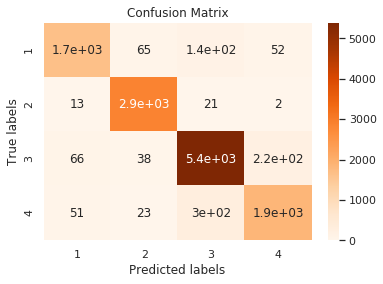

In [20]:
# Train SVC and evaluate on validation data

from sklearn import metrics

# Define model
text_clf = make_pipeline(
    LinearSVC(random_state = 666, C=0.5),
)


# Train model 
_ = text_clf.fit(x_tf, y_train)

# Do prediction on validation dataset 
predicted_val = text_clf.predict(x_val_tf)


# Compute metrics on validation set
print(metrics.classification_report(y_val, predicted_val))
print('F1-score: %.3f' % metrics.f1_score(y_val, predicted_val, average = 'macro'))

df_m = metrics.confusion_matrix(y_val, predicted_val)
ax= plt.subplot()
sn.set(font_scale=1)#for label size
sn.heatmap(df_m, cmap='Oranges', annot=True)# font size
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(text_clf.classes_); ax.yaxis.set_ticklabels(text_clf.classes_);



## Build a prediction model from training data and predict on testing data. (60pts)

### 1 - Train/Build model on whole training dataset

In this section, we will use the ML model found earlier `LinearSVC(C=0.5)`to be trained on the whole labeled dataset and we will show metrics from cross-validation training to be sure of the stability of model on the whole dataset. After thta, we will do prediction on the testing dataset and save predictions.

- Train the model: 

The model is constructed from two blocks : TF-IDF transformer and then the ML algorithm. 

In [ ]:
# Full training dataset

x_full_train = data['Sequence'].replace(',', ' ', regex=True).values
y_full_train = data['Label'].values


In [ ]:
from sklearn.model_selection import cross_validate

# Define the model
text_classifier = make_pipeline(
    TfidfVectorizer(min_df=3, max_df=0.8, ngram_range=(1, 2)),
    LinearSVC(random_state=666, C=0.5),
)


# Evaluate by cv
cv_results = cross_validate(
    text_classifier,
    x_full_train,
    y_full_train,
    cv=5,
    scoring=["precision_macro", "recall_macro", "accuracy", "f1_macro"],
)


In [23]:
cv_results

{'fit_time': array([8.4174161 , 8.35222411, 8.27332735, 8.21521425, 8.20814943]),
 'score_time': array([3.85506558, 3.83217382, 3.87636232, 3.84877586, 3.91003656]),
 'test_accuracy': array([0.92006896, 0.92068966, 0.92021944, 0.92436711, 0.92334822]),
 'test_f1_macro': array([0.90935034, 0.91068517, 0.91060919, 0.9150145 , 0.91346518]),
 'test_precision_macro': array([0.91409508, 0.91587295, 0.91613126, 0.92248947, 0.92007808]),
 'test_recall_macro': array([0.90515933, 0.90612592, 0.90592963, 0.90864241, 0.90765337])}

In [ ]:
# Train on whole dataset
_ = text_classifier.fit(x_full_train, y_full_train)


In [ ]:
# Save the model to disk
import pickle

filename = 'model_svc.sav'
pickle.dump(text_classifier, open(filename, 'wb'))

### 2 - Predict on testing dataset

In [ ]:
# Read data

test_data = pd.read_csv('test.tsv', sep='\t', header=None, names=['Sequence'])

In [27]:
test_data.head()

,Sequence
0,"53jh0,1zqqs,uzlvo,8ak8a,o07v5,j1wvs,wyss6,2mi3..."
1,"llmj9,j6sdx,0iv6t,9lccc,1nfii,un3y8,0rbyu,yxos..."
2,"iv1zb,hofse,cbjfh,v3b1x,wwnmh,p3569,2boj2,4z35..."
3,"0b3kv,j4qdm,sd65k,52d37,5gxco,wcqvi,878l5,wyss..."
4,"skjn9,52d37,0fkd7,xc96r,52d37,jl1d9,ueemv,o07v..."


In [ ]:
# Predict
x_full_test = test_data['Sequence'].replace(',', ' ', regex=True).values
y_test = text_classifier.predict(x_full_test)

# Save to CSV
test_data['Label'] = y_test
test_data.to_csv('test_labeled_svc.csv')


## Comments on how to improve your result (or prediction model). (10pts)

In the previous sections, we have build a machine learning model to classify a sequence of words into 4 classes. There exists many points to improve our results (performance of predictions). Hereunder I will list a non-exaustive list of improvements that we can think about : 

- Finetune TF-IDF hyperparameters + Dimension reduction/hashing.
- Solve the issue of unbalanced classes (by collecting more data, resampling or class_weightening).
- Use a better representation of sentences (embedding). For example if we know the language of the sentenceswe can use recent results from BERT to construct a better contextualized embedding.
- Finetune other ML models. 
- Ensembling/stacking of different ML in order to build a better model.
- Use some Bayesian approaches to build a level of confidence on predictions. 


Here is another approach to solve this problem using neural networks and embedding


## Bonus : Deep Learning Approach

I believe that simple models are always better, this is the reason why I choosed to work with SVM to construct a baseline. Then we can go futher and explore other approaches. In this section I will present a deep learning approach for this problem. 

- First, we construct a tokenized data with a certain number of words in the vocabulary and maximum length of sentences. From the graph of sentence frequency in the EDA, I choose 100 as the sequence length.

In [29]:
from tensorflow.contrib import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 100


# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_val)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# pad sequences with 0s
x_train_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_val_seq = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train_seq.shape)
print('Shape of data test tensor:', x_val_seq.shape)



Using TensorFlow backend.


Found 59552 unique tokens.
Shape of data tensor: (51039, 100)
Shape of data test tensor: (12760, 100)


In [ ]:
# create categorical labels

from keras.utils import to_categorical

# Using a small hack to avoid issues with nb of classes
y_train_cat = to_categorical(y_train-1, num_classes=4)
y_val_cat = to_categorical(y_val-1,num_classes=4)

Here we add some metrics to watch during the training. 

In [ ]:
# Define customized metrics for callback

from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score


class Metrics(Callback):
  def on_train_begin(self, logs={}):
    self.val_f1s = []
    self.val_recalls = []
    self.val_precisions = []

  def on_epoch_end(self, epoch, logs={}):
    val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
    val_targ = self.validation_data[1]
    _val_f1 = f1_score(val_targ, val_predict,  average = 'weighted')
    _val_recall = recall_score(val_targ, val_predict,  average = 'weighted')
    _val_precision = precision_score(val_targ, val_predict,  average = 'weighted')
    self.val_f1s.append(_val_f1)
    self.val_recalls.append(_val_recall)
    self.val_precisions.append(_val_precision)
    print("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))

- Then we will use the embedding technique (that will be trained during the training process) followed by a two dense layers.

<img src="https://i.ibb.co/RHTh0GP/nn.png" alt="nn" border="0">

In [33]:
from keras.models import Sequential
from keras.layers import (
    Dense,
    Embedding,
    Dropout,
    GlobalAveragePooling1D,
)
from keras import optimizers
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(
    Embedding(MAX_NB_WORDS, 50, input_length=MAX_SEQUENCE_LENGTH)  # Embedding size
)

model.add(GlobalAveragePooling1D())
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation="softmax"))

opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

# checkpoint
metrics = Metrics()
# filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath = "weights.best.hdf5"

checkpoint = ModelCheckpoint(
    filepath, monitor="val_acc", verbose=1, save_best_only=True, mode="max"
)
callbacks_list = [checkpoint, metrics]


model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           2500000   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                3264      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 260       
Total params: 2,503,524
Trainable params: 2,503,524
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
# Train and evaluate the model + saving best weights during training

history = model.fit(
    x_train_seq,
    y_train_cat,
    epochs=20,
    batch_size=128,
    verbose=1,
    validation_data=(x_val_seq, y_val_cat),
    callbacks=callbacks_list,
)

W0819 11:39:16.154616 140083436324736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 51039 samples, validate on 12760 samples
Epoch 1/20
51039/51039 [==============================] - 6s 121us/step - loss: 1.0156 - acc: 0.5769 - val_loss: 0.6887 - val_acc: 0.7544

Epoch 00001: val_acc improved from -inf to 0.75439, saving model to weights.best.hdf5
— val_f1: 0.583901 — val_precision: 0.597431 — val_recall 0.573197
Epoch 2/20
 4224/51039 [=>............................] - ETA: 1s - loss: 0.6857 - acc: 0.7590

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


51039/51039 [==============================] - 2s 39us/step - loss: 0.5226 - acc: 0.8321 - val_loss: 0.3980 - val_acc: 0.8792

Epoch 00002: val_acc improved from 0.75439 to 0.87915, saving model to weights.best.hdf5
— val_f1: 0.858085 — val_precision: 0.918605 — val_recall 0.816928
Epoch 3/20
51039/51039 [==============================] - 2s 39us/step - loss: 0.3488 - acc: 0.8900 - val_loss: 0.3191 - val_acc: 0.9001

Epoch 00003: val_acc improved from 0.87915 to 0.90008, saving model to weights.best.hdf5
— val_f1: 0.892977 — val_precision: 0.920319 — val_recall 0.869279
Epoch 4/20
51039/51039 [==============================] - 2s 39us/step - loss: 0.2886 - acc: 0.9075 - val_loss: 0.2896 - val_acc: 0.9081

Epoch 00004: val_acc improved from 0.90008 to 0.90807, saving model to weights.best.hdf5
— val_f1: 0.904010 — val_precision: 0.921741 — val_recall 0.887539
Epoch 5/20
51039/51039 [==============================] - 2s 39us/step - loss: 0.2542 - acc: 0.9190 - val_loss: 0.2737 - val_acc:

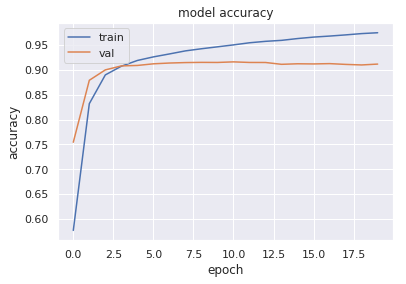

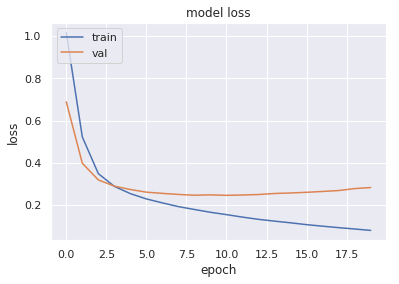

In [35]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Then we can load the best model and evaluate it on validation dataset.

In [ ]:
# Load best weight model

# load weights
model.load_weights("weights.best.hdf5")


# Compile model (required to make predictions)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

              precision    recall  f1-score   support

           1       0.92      0.87      0.89      1924
           2       0.96      0.98      0.97      2896
           3       0.91      0.94      0.93      5709
           4       0.86      0.82      0.84      2231

    accuracy                           0.92     12760
   macro avg       0.91      0.90      0.91     12760
weighted avg       0.92      0.92      0.92     12760

confusion matrix: 

F1-score: 0.916


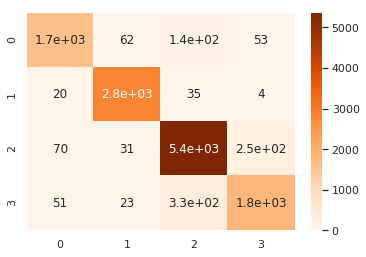

In [37]:
#Deep Learning Model evaluation
from sklearn import metrics

predicted_val_one_hot = model.predict(x_val_seq)
predicted_val = predicted_val_one_hot.argmax(axis = 1)+1

print(metrics.classification_report(y_val, predicted_val))
print('confusion matrix: \n')


df_m = metrics.confusion_matrix(y_val, predicted_val)
sn.set(font_scale=1)#for label size
sn.heatmap(df_m, cmap='Oranges', annot=True)# font size
print('F1-score: %.3f' % metrics.f1_score(y_val, predicted_val, average = 'weighted'))

The perfomance is not improved compared to LinearSVC. 

In [ ]:
# Predict on test data 

# Tokenize
t = tokenizer.texts_to_sequences(x_full_test)
x_t = pad_sequences(t, maxlen=MAX_SEQUENCE_LENGTH)

# Predict
predicted_one_hot = model.predict(x_t)
predicted = predicted_one_hot.argmax(axis = 1)+1

In [ ]:
# Save deeplearning predictions
test_data['Label'] = predicted
test_data.to_csv('test_labeled_DL.csv')

All of these is a minimalist implementation of a machine learning workflow. Every part is subject to an opitimization.

By Imad El Hanafi https://imadelhanafi.com